<a href="https://colab.research.google.com/github/Daniel-Benson-Poe/DS-Unit-2-Linear-Models/blob/master/db_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

Train/Validate/Test Split

In [8]:
# Look at the first five rows of the dataframe
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
# Create train, validate, and test sets; train <= 2016; validate == 2017; test >= 2018
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
# Create cut offs
cut1 = pd.to_datetime('2017-01-01')
cut2 = pd.to_datetime('2018-01-01')
# Create train set
train = df[df['Date'] < cut1]
# Create validation set
val = df[(df['Date'] > cut1) &
         (df['Date'] < cut2)]
# Create test set
test = df[df['Date'] > cut2]

In [10]:
train, val

(        Burrito       Date  Yelp  Google  ... Avocado  Corn  Zucchini  Great
 0    California 2016-01-18   3.5     4.2  ...     NaN   NaN       NaN  False
 1    California 2016-01-24   3.5     3.3  ...     NaN   NaN       NaN  False
 2      Carnitas 2016-01-24   NaN     NaN  ...     NaN   NaN       NaN  False
 3         Asada 2016-01-24   NaN     NaN  ...     NaN   NaN       NaN  False
 4    California 2016-01-27   4.0     3.8  ...     NaN   NaN       NaN   True
 ..          ...        ...   ...     ...  ...     ...   ...       ...    ...
 296  California 2016-12-02   4.0     4.3  ...     NaN   NaN       NaN  False
 297       Other 2016-12-02   NaN     NaN  ...     NaN   NaN       NaN  False
 298  California 2016-12-10   3.5     3.7  ...     NaN   NaN       NaN  False
 299       Asada 2016-12-10   NaN     NaN  ...     NaN   NaN       NaN  False
 300       Other 2016-12-15   4.5     4.6  ...     NaN   NaN       NaN  False
 
 [298 rows x 59 columns],
         Burrito       Date  Yelp  G

Begin with baseline for classification

In [11]:
target = 'Great' # Set target
y_train = train[target] # Create y_train 
y_train.value_counts(normalize=True) # Check the value counts of y in percent format

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [0]:
majority_class = y_train.mode()[0] # Find majority class
y_pred_train = [majority_class]*len(y_train) # Make predicions based on majority class

In [13]:
y_pred_train

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [14]:
# Find the baseline accuracy if guessing majority class for every prediction
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_pred_train)

0.5906040268456376

In [15]:
y_val = val[target]
y_pred = [majority_class]*len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

For fun, let's look at that from a linear regression view: just an attempt to really hammer in the intuition for logistic regression.

In [16]:
train.describe(exclude='number')

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,298,298,22,27,5,168,143,139,149,119,85,43,20,20,5,33,32,11,7,7,1,7,37,6,15,17,4,7,1,4,4,1,4,3,3,2,13,2,1,298
unique,5,110,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,2,1,2
top,California,2016-08-30 00:00:00,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,False
freq,118,29,19,27,3,130,115,101,121,97,63,29,19,17,3,24,24,9,5,4,1,5,33,5,9,9,3,5,1,4,4,1,4,3,3,2,13,1,1,176
first,NaN,2011-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-12-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
val.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,13.000000,13.000000,84.000000,83.000000,22.000000,22.000000,74.000000,74.000000,74.000000,85.000000,80.000000,83.000000,84.000000,83.000000,85.000000,83.000000,85.000000,85.000000,0.0
mean,3.846154,4.353846,7.582024,3.679518,546.181818,0.675277,20.594595,22.247297,0.819595,3.525294,3.876250,3.718675,3.528571,3.681928,3.488824,3.412651,3.674706,4.104706,NaN
std,0.473665,0.359665,2.222494,0.602992,144.445619,0.080468,1.920038,2.042240,0.182490,0.751333,0.908643,0.686841,0.634466,0.782140,0.956008,0.788014,0.785040,0.883298,NaN
min,3.000000,3.800000,4.750000,2.000000,350.000000,0.560000,15.000000,17.000000,0.410000,1.000000,2.000000,2.000000,1.500000,1.500000,0.000000,1.000000,1.000000,1.500000,NaN
25%,3.500000,4.100000,6.750000,3.500000,450.000000,0.619485,19.500000,21.000000,0.720000,3.000000,3.000000,3.500000,3.000000,3.000000,3.000000,3.000000,3.500000,3.500000,NaN
50%,4.000000,4.400000,7.240000,3.800000,540.000000,0.658099,20.750000,22.000000,0.795000,3.500000,4.000000,4.000000,3.500000,3.800000,3.500000,3.500000,3.800000,4.000000,NaN
75%,4.000000,4.500000,7.900000,4.000000,595.000000,0.721726,22.000000,23.000000,0.917500,4.000000,4.500000,4.000000,4.000000,4.100000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,5.000000,25.000000,5.000000,925.000000,0.865672,24.500000,29.000000,1.540000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [18]:
# 1. Import estimator class
from sklearn.linear_model import LinearRegression

# 2. Instantiate class
linear_reg = LinearRegression()

# 3. Arrange X feature matrices (already did y target vectors)
features = ['Yelp',	'Google',	'Cost',	'Hunger',	'Mass (g)',	'Density (g/mL)',
            'Length',	'Circum',	'Volume',	'Tortilla',	'Temp',	'Meat',	'Fillings',
            'Meat:filling',	'Uniformity',	'Salsa',	'Synergy',	'Wrap',	'Queso']
X_train = train[features]
X_val = val[features]

# Impute missing values
from sklearn.impute import SimpleImputer # import imputer
imputer = SimpleImputer() # instantiate imputer
X_train_imputed = imputer.fit_transform(X_train) # fit_transform X_train
X_val_imputed = imputer.transform(X_val) # transform X_val

# 4. Fit the model
linear_reg.fit(X_train_imputed, y_train) 

# 5. Apply model to new data
linear_reg.predict(X_val_imputed)

array([ 0.53160422,  0.49639941,  0.66055462,  0.59571679, -0.12212491,
        0.13538657,  0.83359786,  0.49877043, -0.02481807,  0.77643143,
        0.75694877, -0.05553553,  0.28293718,  0.31358049,  1.03604807,
        0.41605914,  0.40906669,  0.64362603,  0.63899424,  1.11097651,
        0.63493382,  0.47753632,  0.1188471 ,  0.54810157,  0.65757879,
        0.68587925,  0.70437383,  0.42792166,  0.48334497,  0.68371865,
        0.7611789 ,  0.47186949,  0.3721218 ,  0.39950396, -0.09902347,
       -0.01878977,  0.42972242,  0.57873428,  0.40398879,  0.50102965,
        0.41968988,  0.43513575,  0.47879177,  0.60973024,  0.61424744,
        0.4568679 ,  0.16016893,  0.19973556,  0.66299179, -0.19781305,
        0.22785082,  0.45941645,  0.84638977,  0.76738021,  0.43725022,
        0.16614088,  0.2230091 ,  0.18621903,  0.38512429,  0.38367767,
       -0.44962382,  0.33373709, -0.08414513,  0.47801874,  0.49522269,
        0.84514189,  0.56011928,  0.98405841,  0.5797118 ,  0.40

In [19]:
features

['Yelp',
 'Google',
 'Cost',
 'Hunger',
 'Mass (g)',
 'Density (g/mL)',
 'Length',
 'Circum',
 'Volume',
 'Tortilla',
 'Temp',
 'Meat',
 'Fillings',
 'Meat:filling',
 'Uniformity',
 'Salsa',
 'Synergy',
 'Wrap',
 'Queso']

In [20]:
# Get coefficients
linear_reg.coef_

array([ 0.11004571, -0.13194436,  0.03994151,  0.0102132 ,  0.10600872,
        0.18149784, -2.6815502 ,  0.05838255,  0.05195749,  0.09834228,
        0.09506547,  0.06605855,  0.01605043,  0.03328156,  0.13140973,
        0.00596809])

In [21]:
X_train.sample(10)

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
183,4.0,3.9,4.99,3.5,NaN,NaN,23.0,19.0,0.66,3.0,3.0,3.0,3.0,2.5,2.0,2.5,3.0,4.0,NaN
63,NaN,NaN,6.60,3.0,NaN,NaN,NaN,NaN,NaN,3.0,2.5,3.0,4.0,2.0,1.0,3.0,3.0,5.0,NaN
232,NaN,NaN,7.49,4.1,NaN,NaN,NaN,NaN,NaN,4.0,4.5,4.5,4.5,4.7,4.5,4.2,4.5,5.0,NaN
289,NaN,NaN,6.99,4.0,NaN,NaN,NaN,NaN,NaN,4.5,4.5,4.0,4.5,4.0,4.0,3.5,4.5,5.0,NaN
14,NaN,NaN,6.25,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,2.0,2.0,4.0,4.0,NaN,3.0,4.0,NaN
83,NaN,NaN,7.49,4.0,NaN,NaN,16.5,25.0,0.82,4.0,3.5,4.0,4.0,4.5,5.0,4.5,5.0,4.5,NaN
42,4.5,4.1,6.99,4.0,NaN,NaN,NaN,NaN,NaN,4.0,4.5,4.0,3.5,4.0,2.5,2.0,4.0,4.0,NaN
157,NaN,NaN,7.00,3.0,NaN,NaN,19.0,24.0,0.87,3.5,2.0,3.0,4.0,2.0,4.0,3.0,3.0,4.0,NaN
52,4.5,4.7,7.99,3.5,NaN,NaN,NaN,NaN,NaN,4.0,4.0,2.0,3.0,1.5,3.0,2.5,1.0,3.0,NaN
30,4.0,4.4,6.60,3.5,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.0,3.5,4.5,4.0,3.5,4.0,1.0,NaN


In [0]:
test_case = [[3.6, 4.3, 6.7, 3.5, 19.4, 22., 0.7, 3.4, 3.7, 3.3, 3.5, 
             3.5, 3.2, 3.6, 3.5, 3.7]]

In [23]:
linear_reg.predict(test_case)

array([0.45175452])

Now logistic regression

In [24]:
X_train.mean()

Yelp               3.897183
Google             4.142254
Cost               6.896781
Hunger             3.445286
Mass (g)                NaN
Density (g/mL)          NaN
Length            19.829886
Circum            22.042241
Volume             0.770920
Tortilla           3.472315
Temp               3.706360
Meat               3.551215
Fillings           3.519024
Meat:filling       3.528870
Uniformity         3.395946
Salsa              3.324640
Synergy            3.540203
Wrap               3.955068
Queso                   NaN
dtype: float64

In [25]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

Validation Accuracy 0.8235294117647058


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [26]:
X_train_imputed, X_train

(array([[3.5       , 4.2       , 6.49      , ..., 4.        , 4.        ,
         4.        ],
        [3.5       , 3.3       , 5.45      , ..., 3.5       , 2.5       ,
         5.        ],
        [3.8971831 , 4.14225352, 4.85      , ..., 3.        , 3.        ,
         5.        ],
        ...,
        [3.5       , 3.7       , 7.75      , ..., 2.2       , 3.3       ,
         4.5       ],
        [3.8971831 , 4.14225352, 7.75      , ..., 2.        , 2.        ,
         4.        ],
        [4.5       , 4.6       , 6.99      , ..., 3.32464029, 3.8       ,
         2.        ]]),
      Yelp  Google  Cost  Hunger  ...  Salsa  Synergy  Wrap  Queso
 0     3.5     4.2  6.49     3.0  ...    4.0      4.0   4.0    NaN
 1     3.5     3.3  5.45     3.5  ...    3.5      2.5   5.0    NaN
 2     NaN     NaN  4.85     1.5  ...    3.0      3.0   5.0    NaN
 3     NaN     NaN  5.25     2.0  ...    4.0      4.0   5.0    NaN
 4     4.0     3.8  6.59     4.0  ...    2.5      4.5   4.0    NaN
 ..    

In [27]:
# Predictions look like this:
log_reg.predict(X_val_imputed)

array([False, False,  True,  True, False, False,  True, False, False,
        True,  True, False, False, False,  True, False, False,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False, False,  True,  True, False, False,  True, False, False,
        True,  True, False, False, False,  True, False,  True,  True,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True, False,  True,  True])

In [28]:
# Find the math
log_reg.coef_

array([[ 1.79710014e-04, -1.57219640e+00,  2.01318113e-01,
         1.03123980e-01, -2.19245539e-01, -4.49997092e-01,
         1.57182263e+00,  5.73946380e-01,  3.25829976e-01,
         1.11161482e+00,  9.58278844e-01,  9.04949469e-01,
        -1.22955903e-02,  4.14216472e-01,  1.49935231e+00,
         5.10509953e-02]])

In [29]:
log_reg.intercept_

array([-3.81167906])

In [0]:
# Sigmoid squishing function
import numpy as np

def sigmoid(x):
  return 1 / (1 + np.e**(-x))


In [31]:
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case))) # Chance target = 1, or that the burrito is considered 'Great'

array([[0.15714008]])

In [32]:
1 - sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case))) # Chance target = 0, or burrito is not considered 'Great'

array([[0.84285992]])

Check model's validation accuracy

In [33]:
# Set X features
features = ['Yelp',	'Google',	'Cost',	'Hunger', 'Length',	'Circum',	'Volume',	
            'Tortilla',	'Temp',	'Meat',	'Fillings', 'Meat:filling',	
            'Uniformity',	'Salsa',	'Synergy',	'Wrap']

target = 'Great'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, X_val.shape

((298, 16), (85, 16))

In [0]:
# Important imports
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

In [35]:
# One hot encoding
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True) # Instantiate one hot encoder
X_train_enc = encoder.fit_transform(X_train) # Fit transform X_train
X_val_enc = encoder.transform(X_val) # Transform X validation
X_train_enc.shape, X_val_enc.shape

((298, 16), (85, 16))

In [36]:
X_val_enc.head()

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
301,NaN,NaN,6.60,NaN,23.0,20.5,0.77,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5
302,NaN,NaN,6.60,NaN,20.5,21.5,0.75,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0
303,NaN,NaN,8.50,3.9,21.0,21.0,0.74,3.0,4.5,4.1,3.0,3.7,4.0,4.3,4.20,5.0
304,NaN,NaN,7.90,4.0,20.5,21.0,0.72,3.5,4.0,4.0,3.0,4.0,4.5,4.0,3.80,4.8
305,NaN,NaN,4.99,3.5,18.5,22.5,0.75,2.5,4.5,3.0,2.5,3.0,3.0,2.0,2.00,4.0


In [37]:
# Impute NaN values
imputer = SimpleImputer(strategy='mean') # Instantiate imputer
X_train_imp = imputer.fit_transform(X_train_enc) # Fit transform X_train_encoder
X_val_imp = imputer.transform(X_val_enc) # transform X validation encoder
X_train_imp.shape, X_val_imp.shape

((298, 16), (85, 16))

In [39]:
X_val_imp

array([[ 3.8971831 ,  4.14225352,  6.6       , ...,  1.5       ,
         3.5       ,  4.5       ],
       [ 3.8971831 ,  4.14225352,  6.6       , ...,  4.2       ,
         3.75      ,  5.        ],
       [ 3.8971831 ,  4.14225352,  8.5       , ...,  4.3       ,
         4.2       ,  5.        ],
       ...,
       [ 4.        ,  4.5       , 11.5       , ...,  3.5       ,
         4.        ,  2.        ],
       [ 3.8971831 ,  4.14225352,  7.89      , ...,  3.5       ,
         4.3       ,  4.5       ],
       [ 3.8971831 ,  4.14225352,  7.89      , ...,  5.        ,
         5.        ,  3.        ]])

In [0]:
# Convert those to dataframes
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train_enc.columns)
X_val_imp = pd.DataFrame(X_val_imp, columns=X_val_enc.columns)

In [42]:
X_train_imp.head()

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,3.500000,4.200000,6.49,3.0,19.829886,22.042241,0.77092,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0
1,3.500000,3.300000,5.45,3.5,19.829886,22.042241,0.77092,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0
2,3.897183,4.142254,4.85,1.5,19.829886,22.042241,0.77092,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0
3,3.897183,4.142254,5.25,2.0,19.829886,22.042241,0.77092,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0
4,4.000000,3.800000,6.59,4.0,19.829886,22.042241,0.77092,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0


In [0]:
# Run scaler; forces values onto the same scale
scaler = StandardScaler() # Instantiate scaler
X_train_sc = scaler.fit_transform(X_train_imp) # fit transform X train impute
X_val_sc = scaler.transform(X_val_imp) # transform X validation impute

In [45]:
X_train_sc

array([[-1.71200227e+00,  3.20514492e-01, -3.39805235e-01, ...,
         7.21245234e-01,  5.00993379e-01,  3.86864734e-02],
       [-1.71200227e+00, -4.67482113e+00, -1.20857147e+00, ...,
         1.87274062e-01, -1.13340089e+00,  8.99678662e-01],
       [ 1.91418451e-15, -4.92972144e-15, -1.70978276e+00, ...,
        -3.46697110e-01, -5.88602801e-01,  8.99678662e-01],
       ...,
       [-1.71200227e+00, -2.45467196e+00,  7.12738477e-01, ...,
        -1.20105098e+00, -2.61723947e-01,  4.69182568e-01],
       [ 1.91418451e-15, -4.92972144e-15,  7.12738477e-01, ...,
        -1.41463945e+00, -1.67819898e+00,  3.86864734e-02],
       [ 2.59835806e+00,  2.54066366e+00,  7.78708410e-02, ...,
         0.00000000e+00,  2.83074143e-01, -1.68329790e+00]])

In [0]:
# Convert those to dataframes
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
X_val_sc = pd.DataFrame(X_val_sc, columns=X_val_enc.columns)

In [47]:
X_train_sc.head()

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,-1.712002e+00,3.205145e-01,-0.339805,-0.524307,0.0,0.0,0.0,-0.593162,1.340696,-0.645992,-0.022447,0.458224,0.557478,0.721245,0.500993,0.038686
1,-1.712002e+00,-4.674821e+00,-1.208571,0.064423,0.0,0.0,0.0,-1.849023,-0.213867,-1.231964,-1.202403,-1.486989,0.557478,0.187274,-1.133401,0.899679
2,1.914185e-15,-4.929721e-15,-1.709783,-2.290496,0.0,0.0,0.0,-0.593162,-1.768429,-1.231964,-0.612425,0.944528,0.557478,-0.346697,-0.588603,0.899679
3,1.914185e-15,-4.929721e-15,-1.375642,-1.701766,0.0,0.0,0.0,-0.593162,-1.768429,-0.060021,-0.612425,0.458224,1.480371,0.721245,0.500993,0.899679
4,4.431779e-01,-1.899635e+00,-0.256270,0.653153,0.0,0.0,0.0,0.662698,1.340696,0.525950,-0.022447,0.944528,1.480371,-0.880668,1.045791,0.038686


In [48]:
# Logistic Regression CV
model = LogisticRegressionCV() # Instantiate 
model.fit(X_train_sc, y_train) # fit model with X train scaler and y train (target)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [49]:
# Print validation score
print(f'Validation Score: {model.score(X_val_sc, y_val)}')

Validation Score: 0.8823529411764706


Let's look at our coefficients

In [50]:
coefs = pd.Series(model.coef_[0], X_train_sc.columns)
coefs

Yelp            0.093854
Google         -0.004266
Cost            0.195676
Hunger          0.119757
Length          0.042483
Circum          0.000300
Volume         -0.002146
Tortilla        0.309644
Temp            0.284428
Meat            0.577196
Fillings        0.579293
Meat:filling    0.492726
Uniformity      0.165661
Salsa           0.257620
Synergy         0.685466
Wrap            0.102378
dtype: float64

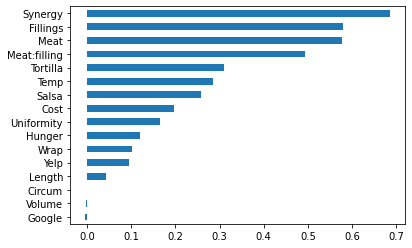

In [52]:
# Plot those
coefs.sort_values().plot.barh();

Get model's test accuracy

In [53]:
X_test = test[features] # X features
X_test_enc = encoder.transform(X_test) # transform encoder using X_test
X_test_imp = imputer.transform(X_test_enc) # Impute nan values
X_test_scaled = scaler.transform(X_test_imp) # Scale imputed X_test so values are on same scale
X_test_scaled

array([[ 1.91418451e-15, -4.92972144e-15,  9.21576515e-01,
         6.53153184e-01,  1.10673835e+00,  0.00000000e+00,
         0.00000000e+00,  1.29062863e+00,  1.34069563e+00,
         1.69789203e+00,  1.74748664e+00,  9.44527829e-01,
         1.48037108e+00, -3.46697110e-01,  1.59058956e+00,
         8.99678662e-01],
       [ 1.91418451e-15, -4.92972144e-15,  2.95062401e-01,
         6.53153184e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  6.62698293e-01,  1.34069563e+00,
         5.25949777e-01,  1.74748664e+00,  1.43083126e+00,
        -3.65415944e-01, -3.46697110e-01,  5.00993379e-01,
         8.99678662e-01],
       [ 2.59835806e+00, -1.89963467e+00, -2.26111518e+00,
        -5.24306577e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -5.93162383e-01,  1.34069563e+00,
        -1.81793472e+00, -1.79238058e+00,  4.58224401e-01,
        -2.21120297e+00,  7.21245234e-01, -5.88602801e-01,
         3.86864734e-02],
       [-1.71200227e+00,  8.75551784e

In [63]:
# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred

array([ True,  True, False,  True, False, False,  True,  True, False,
        True,  True, False,  True, False,  True,  True,  True, False,
       False, False, False,  True, False,  True,  True, False, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True])

In [65]:
test_answers = np.array(test['Great'])
test_answers

array([ True, False, False,  True, False,  True,  True,  True, False,
        True, False, False, False,  True,  True,  True, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True])

In [77]:
test_counts = pd.Series(test_answers == y_pred).value_counts()
test_counts

True     29
False     9
dtype: int64

In [76]:
test.shape

(38, 59)

In [81]:
# There are 29 correct answers and 9 incorrect answers. This gives us a test accuracy of:
test_counts[1] / test.shape[0]

0.7631578947368421

In [0]:
# We have a 76.3% test accuracy using this model.